# Understanding the structure of the raw data

In this notebook, we make a unique id for each project, made from the project title and the project number in the form `{number}_{title}`.

We then take `2024.02.16-all-contracts-dataset.csv` and filter out any unique IDs which have more than one estimated cost/completion date associated with them. These are projects that we cannot uniquely identify because they have the same number and title, yet different datapoints.

We output the result as `2024.02.18-all-unique-contracts-dataset.csv`. These are all data where we have completion percentages and can identify the unique projects through various records.

# 01: Do the original contract amounts and orignal completion dates remain consistent throughtout each mention of a project ?

In [68]:
import numpy as np
import pandas as pd

In [69]:
# Import dataset

df = pd.read_csv("../data/datasets/all-contracts.csv")

df["Data as of Date"] = pd.to_datetime(df["Data as of Date"])
df["Submission Date"] = pd.to_datetime(df["Submission Date"])
df["Start Date"] = pd.to_datetime(df["Start Date"])
df["Contract Award Date"] = pd.to_datetime(df["Contract Award Date"])
df["Actual Construction Completion Date"] = pd.to_datetime(df["Actual Construction Completion Date"])

/var/folders/z7/sh9lp16n1f997dpqzbly6cfh0000gp/T/ipykernel_31090/3785161670.py:3: DtypeWarning: Columns (12,21,29,30) have mixed types. Specify dtype option on import or set low_memory=False.
  df = pd.read_csv("./2024.02.16-all-contracts-dataset.csv")


In [70]:
# Make unique id for contracts
df["unique_id"] = None
df.loc[df["Project Title"].isna(), "Project Title"] = ""

for i, row in df.iterrows():
    if row["Project Title"] == "":
        df.loc[i, "unique_id"] = f"{row["Project Number"]}_"
    df.loc[i, "unique_id"] = f"{row["Project Number"]}_{row["Project Title"].lower()}"

df[["Project Number", "Project Title", "unique_id"]]

,Project Number,Project Title,unique_id
0,495,"APPLIED INSTRUCTION FACILITY, MAWTS","495_applied instruction facility, mawts"
1,020,MARINE CORPS RESERVE CENTER,020_marine corps reserve center
2,026,"BACHELOR ENLISTED QUARTERS, LAS PULGAS","026_bachelor enlisted quarters, las pulgas"
3,043,"BACHELOR ENLISTED QUARTERS, PICO (24) AREA","043_bachelor enlisted quarters, pico (24) area"
4,046,"BACHELOR ENLISTED QUARTERS, AREA 41","046_bachelor enlisted quarters, area 41"
...,...,...,...
40605,P-888,"Close Quarters Combat Range, Phase II","P-888_close quarters combat range, phase ii"
40606,TMKH043055,SOF Training Facility,TMKH043055_sof training facility
40607,NGA021,Data Ctr West #1 Power & Cooling Upgrade,NGA021_data ctr west #1 power & cooling upgrade
40608,NGA013,Technology Center Third Floor Fit-out,NGA013_technology center third floor fit-out


In [71]:
# Make the dictionaries
# We want this format: { ProjectID_ProjectTitle_PctComplete : set(est_cost1, est_cost2) }
# Values which are sets of length > 1 may indicate that the 'original' budget was updated

og_cost_dict = {}
og_completion_dict = {}

for i, row in df.iterrows():
    
    cost = row['Estimated Cost']
    completion = row['Estimated Construction Completion Date']
        
    og_cost_dict.setdefault(
        row["unique_id"], 
        set([cost])
    )

    og_completion_dict.setdefault(
        row["unique_id"], 
        set([completion])
    )

    og_cost_dict[row["unique_id"]].add(cost)
    og_completion_dict[row["unique_id"]].add(completion)

In [72]:
# Examine instances wherein we have more than one cost associated with a given project 
# number/title combination
for project, costs in og_cost_dict.items():
    if len(costs) > 1:
        print(project, costs)

184_potable water plant modernization {35656000.0, 30101000.0}
582_undersea surveillance scif facility {3923000.0, 4129000.0}
TYFR064009_improve family housing, ph c {1802000.0, 1118000.0, 1801814.0}
FJXT053012_c-17 alter hangars (bldgs 715, 945) {11816000.0, 58000.0, 3397000.0}
NZAS034008_replace family housing {44632000.0, 21279000.0, 14612000.0, 10264000.0, 12893000.0, 738000.0, 45487000.0, 16203000.0, 3711000.0}
TYFR074035_improve family housing, ph d {2310000.0, 1402000.0, 1528000.0}
CRWU073005_military working dog kennel {240000.0, 1312000.0}
NVZR053714B_replace uscentcom headquarters {896000.0, 2476000.0, 61068000.0}
XLWU063009_1 af affor center, ph 3 {7529000.0, 306000.0}
ALDA053001B_multi-aircraft maintenance hanger {15238000.0, 15238069.0}
ALUA073008A_facility replacements {26245000.0, 26244838.0}
LXEZ084216_improve family housing, ph 8 {140248000.0, 696000.0, 3452000.0, 200000.0, 76000.0, 500000.0, 4000.0, 405000.0, 37000.0, 89000.0, 30000.0, 74000.0, 66000.0, 43000.0}
LJYC0

In [73]:
# Examine instances wherein we have more than one completion date associated with a given project 
# number/title combination
for project, dates in og_completion_dict.items():
    if len(dates) > 1:
        print(project, dates)

220_ammunition supply point {'2014-05-14', '2014-04-30'}
273_t-6b jpats training ops paraloft facility {'2013-10-29', '2012-01-10'}
629_armed forces reserve center {'2015-12-28', nan, '2016-01-12', '2013-04-11', '2016-01-11'}
1006_defense access road improvements {nan, '2013-11-15'}
132_sof cafeteria {'2013-02-23', '2012-12-21'}
908_consolidated operations & support facility {'2015-07-27', '2014-09-11'}
954_waterfront development, phase 3 {'2014-03-25', '2014-11-26'}
012_container staging and loading lot {'2013-12-05', '2013-05-03'}
017_hardstand extension {'2013-12-05', '2013-05-03'}
024_container storage lot {'2013-12-05', '2013-05-03'}
203_aviation simulator training facility {'2013-08-29', '2013-11-13'}
444_training and simulator facility {'2013-11-27', '2014-03-11', '2013-09-03'}
454_f-35b aircraft hangar for frs-2 {'2013-11-27', '2014-03-11', '2013-09-03'}
162_agile chemical facility phase 2 {'2016-08-22', '2014-06-16', '2012-12-21'}
743_navy ord cargo logistics training complex 

In [74]:
ambigous_cost = []
ambigous_completion = []

for id, costs in og_cost_dict.items():
    if len(costs) > 1:
        ambigous_cost.append(id)

for id, dates in og_completion_dict.items():
    if len(dates) > 1:
        ambigous_completion.append(id)

ambiguous_projects = ambigous_cost + ambigous_completion

df2 = df[
    ~df.unique_id.isin(ambiguous_projects)
]

df2.shape
# We get 19342 datapoints if we exclude projects where we might see duplicates

(19342, 34)

In [75]:
df2.unique_id.nunique()
# We get 2441 projects in total which we are unambiguous

2441

In [76]:
df2.unique_id.value_counts().median()
# The projects have an average of 6 datapoints associated with them

6.0

array([[<Axes: title={'center': 'Completion Percentage'}>]], dtype=object)

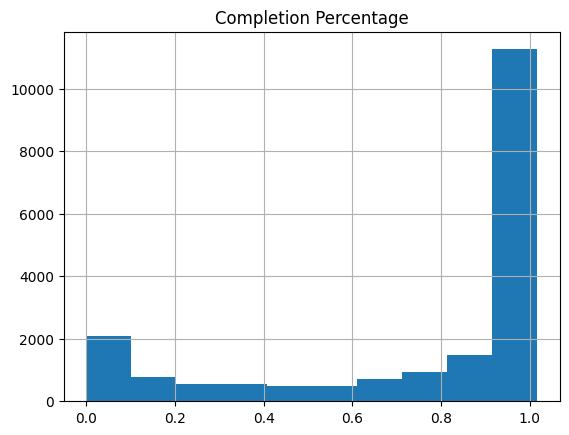

In [77]:
import matplotlib.pyplot as plt

df2.hist(column = "Completion Percentage")
# Distribution of pct complete data - vast majority are at 100% completion

## 02: What is the relationship between submission date and data as of date?

We would like to clarify the meaning of data as of date. 

**Hypthesis:** `Data as of Date` is the date when the data were collected, and then `Submission Date` would be when the data were submitted to records.

In some instances we have one but not the other - we can analyse both if we understand what they mean.

- What is the average/maximum differece betwen them? If its low, we may be able to use them interchangably

- Is the submission date ever before data as of date? This wouldn't make sense if our hypothesis is true


### Conclusions

- `Data as of Date` almost always corresponds to the month and year in the file name. The only exception is for April 2014, where half of the dates are April 2014 and half are April 2013, one year prior

- `Submission date` is generally a month after the record was produced. ie, for the November 2013 record, submission dates were given in December 2013, about one month in the future.

- Its unclear what the Submission date refers to, so we should just leave it.

- Data as of date seems to refer to the date at which the data are considered relevent. We can therefore use it to allign completion percentage with schedule progress. 

In [78]:
df_sub = df2[~(df2["Submission Date"].isna() | df2["Data as of Date"].isna())]

(df_sub["Submission Date"] - df_sub["Data as of Date"]).apply(abs).median(), (df_sub["Submission Date"] - df_sub["Data as of Date"]).apply(abs).max()
# Average is six days, max is about one year

(Timedelta('6 days 00:00:00'), Timedelta('359 days 00:00:00'))

In [79]:
df2[df2["Submission Date"] < df2["Data as of Date"]]

# There are 307 instances where the data were submitted before the "data as of date"

,archive_year,archive_month,archive_filename,Submission Date,Data as of Date,Project Title,Project Number,Fiscal Year,Component,Project Type,...,Completion Percentage,Diverted Funds,Remarks,Recipient Project,Recipient Site,Prime Contract Number,Parent Project Number,Sub Project Number,Estimated Cost (exc. contingency),unique_id
21706,2014,4,"MilCon Status Report - May, 2014 .xlsx",2013-06-06,2014-05-31,Pentagon Athletic Club (PAC) Phase II,2009-1,2009.0,WHS,Major construction,...,1.00,-401000.0,$.400.83K to SAL ($99K remaining),NaN,NaN,NaN,NaN,NaN,4.538095e+06,2009-1_pentagon athletic club (pac) phase ii
21707,2014,4,"MilCon Status Report - May, 2014 .xlsx",2013-06-06,2014-05-31,Pentagon Emergency Response Center (PERC),2009-3,2009.0,WHS,Major construction,...,1.00,-683000.0,$683.49K to SAL,NaN,NaN,NaN,NaN,NaN,1.187524e+07,2009-3_pentagon emergency response center (perc)
21708,2014,4,"MilCon Status Report - May, 2014 .xlsx",2013-06-06,2014-05-31,Power Plant Modernization - Phase Two,2009-2,2009.0,WHS,Major construction,...,1.00,NaN,PROJECT COMPLETE / CLOSED OUT,NaN,NaN,NaN,NaN,NaN,1.171429e+07,2009-2 _power plant modernization - phase two
21710,2014,4,"MilCon Status Report - May, 2014 .xlsx",2013-06-06,2014-05-31,Secondary UPS System,2010-2,2010.0,WHS,Major construction,...,0.99,NaN,Equipment cooling issue must be resolved befor...,NaN,NaN,NaN,NaN,NaN,4.944762e+06,2010-2_secondary ups system
21711,2014,4,"MilCon Status Report - May, 2014 .xlsx",2013-06-06,2014-05-31,Power Plant Modernization Phase 3 West Power P...,2011-1,2011.0,WHS,Major construction,...,0.09,-4001000.0,"Project at 35% design, funds absconded by sequ...",NaN,NaN,NaN,NaN,NaN,4.151810e+07,2011-1_power plant modernization phase 3 west ...
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
22320,2014,4,"MilCon Status Report - May, 2014 .xlsx",2013-06-19,2014-05-31,JBAB paving of gravel parking lot,DIA11-002,2010.0,DIA,Minor Construction,...,0.99,700000000.0,Approp. $2994 - reprogramming action completed...,NaN,NaN,NaN,NaN,NaN,2.841905e+06,DIA11-002_jbab paving of gravel parking lot
22323,2014,4,"MilCon Status Report - May, 2014 .xlsx",2013-06-19,2014-05-31,DIAC chilled water project for data center,DIA12000003,2012.0,DIA,Minor Construction,...,0.00,NaN,"Approp. - $1,121 - NAVFAC awarded the design c...",NaN,NaN,NaN,NaN,NaN,0.000000e+00,DIA12000003_diac chilled water project for dat...
22324,2014,4,"MilCon Status Report - May, 2014 .xlsx",2013-06-19,2014-05-31,DIAC cooling tower for data center,DIA12000003,2012.0,DIA,Minor Construction,...,0.00,NaN,Approp. - $941 - NAVFAC awarded the design con...,NaN,NaN,NaN,NaN,NaN,0.000000e+00,DIA12000003_diac cooling tower for data center
22325,2014,4,"MilCon Status Report - May, 2014 .xlsx",2013-06-19,2014-05-31,Uninterrupted Power Supply (UPS) for data center,DIA12000002,2012.0,DIA,Minor Construction,...,0.00,NaN,"Approp. - $1,076 - NAVFAC awarded the design c...",NaN,NaN,NaN,NaN,NaN,0.000000e+00,DIA12000002_uninterrupted power supply (ups) f...


In [80]:
df2[df2["Submission Date"] < df2["Data as of Date"]].unique_id.value_counts()
# These are all unique projects, apart from 647_readiness... which appears twice

unique_id
647_readiness & control (r&c) facility redundant chilled water distribution piping    2
2009-1_pentagon athletic club (pac) phase ii                                          1
060344_cap 060344 air sppt ops squadron                                               1
067545_automated record fire range                                                    1
066099_battalion headquarters building                                                1
                                                                                     ..
043335_nco academy                                                                    1
071119_071119 training aids center fy11                                               1
061383_construction of new barrack fy011                                              1
057317_brks cplx/3d bde - ph iv                                                       1
ECIP 120001_chiller plant optimization                                                1
Name: count, Length: 3

In [81]:
df2[df2["Submission Date"] < df2["Data as of Date"]]["Data as of Date"].value_counts()
# They all have the exact same data as of date value. 

Data as of Date
2014-05-31    307
Name: count, dtype: int64

In [82]:
df2[df2["Submission Date"] < df2["Data as of Date"]].archive_filename.value_counts()
# They all come from the same file

archive_filename
MilCon Status Report - May, 2014 .xlsx    307
Name: count, dtype: int64

In [83]:
for f in df_sub.archive_filename.unique().tolist():
    print(f)
    display(df_sub[df_sub.archive_filename == f]["Data as of Date"].value_counts())
    print("\n")

# In all cases (except April 2014) the data as of date corresponds to the month/year of the record itself

MilCon Status Report - May, 2013.xlsx


Data as of Date
2013-05-31    967
Name: count, dtype: int64



MilCon Status Report - September, 2013.xlsx


Data as of Date
2013-09-30    997
Name: count, dtype: int64



MilCon Status Report - July, 2013.xlsx


Data as of Date
2013-07-31    537
2013-06-28      2
Name: count, dtype: int64



MilCon Status Report - August, 2013.xlsx


Data as of Date
2013-08-31    1096
Name: count, dtype: int64



MilCon Status Report - November, 2013.xlsx


Data as of Date
2013-11-30    781
Name: count, dtype: int64



MilCon Status Report - June, 2013.xlsx


Data as of Date
2013-06-30    1098
2013-06-28       2
Name: count, dtype: int64



MilCon Status Report - January, 2014 .xlsx


Data as of Date
2014-01-31    768
Name: count, dtype: int64



MilCon Status Report - March, 2014 .xlsx


Data as of Date
2014-03-31    858
Name: count, dtype: int64



MilCon Status Report - February, 2014 .xlsx


Data as of Date
2014-02-28    766
Name: count, dtype: int64



MilCon Status Report - May, 2014 .xlsx


Data as of Date
2014-05-31    790
Name: count, dtype: int64



MilCon Status Report - September, 2014 .xlsx


Data as of Date
2014-09-30    682
Name: count, dtype: int64



MilCon Status Report - June, 2014 .xlsx


Data as of Date
2014-06-30    832
Name: count, dtype: int64



MilCon Status Report - August, 2014 .xlsx


Data as of Date
2014-08-31    833
Name: count, dtype: int64



MilCon Status Report - July, 2014 .xlsx


Data as of Date
2014-07-31    830
Name: count, dtype: int64



MilCon Status Report - April, 2014 .xlsx


Data as of Date
2014-04-30    525
2013-04-30    302
2014-04-15     14
Name: count, dtype: int64

In [84]:
for f in df_sub.archive_filename.unique().tolist():
    print(f)
    display(df_sub[df_sub.archive_filename == f]["Submission Date"].value_counts())
    print("\n")

# Submission dates vary more, but generally come the following month after the record was produced

MilCon Status Report - May, 2013.xlsx


Submission Date
2013-06-12    541
2013-06-03    261
2013-06-13     90
2013-06-05     72
2013-06-06      3
Name: count, dtype: int64



MilCon Status Report - September, 2013.xlsx


Submission Date
2013-10-07    731
2013-10-22     99
2013-10-16     66
2013-10-04     45
2013-10-11     17
2013-10-18     16
2013-10-05      6
2013-10-17      6
2013-10-10      5
2013-10-01      3
2013-10-03      3
Name: count, dtype: int64



MilCon Status Report - July, 2013.xlsx


Submission Date
2013-08-06    246
2013-08-15    208
2013-08-13     50
2013-08-02     24
2013-08-05      6
2013-08-01      3
2013-07-03      2
Name: count, dtype: int64



MilCon Status Report - August, 2013.xlsx


Submission Date
2013-09-05    552
2013-09-04    260
2013-09-13    136
2013-09-16     84
2013-09-11     57
2013-09-06      4
2013-09-20      3
Name: count, dtype: int64



MilCon Status Report - November, 2013.xlsx


Submission Date
2013-12-05    377
2013-12-04    159
2013-12-16     91
2013-12-12     82
2013-12-13     48
2013-12-06     24
Name: count, dtype: int64



MilCon Status Report - June, 2013.xlsx


Submission Date
2013-07-02    788
2013-07-15    133
2013-07-17     84
2013-07-05     63
2013-07-03     24
2013-07-19      8
Name: count, dtype: int64



MilCon Status Report - January, 2014 .xlsx


Submission Date
2014-02-05    415
2014-02-19    153
2014-02-13     91
2014-02-12     78
2014-02-04     14
2014-02-06      6
2014-02-11      6
2014-02-18      5
Name: count, dtype: int64



MilCon Status Report - March, 2014 .xlsx


Submission Date
2014-04-07    363
2014-04-04    237
2014-04-15    131
2014-04-16     94
2014-04-08     14
2014-04-18      7
2014-04-09      6
2014-04-14      5
2014-04-17      1
Name: count, dtype: int64



MilCon Status Report - February, 2014 .xlsx


Submission Date
2014-03-06    377
2014-03-10    151
2014-03-21     91
2014-03-13     80
2014-03-04     49
2014-03-05     10
2014-03-12      5
2014-03-24      3
Name: count, dtype: int64



MilCon Status Report - May, 2014 .xlsx


Submission Date
2014-06-05    483
2013-06-11    127
2013-06-16     82
2013-06-06     81
2013-06-19     12
2013-06-09      5
Name: count, dtype: int64



MilCon Status Report - September, 2014 .xlsx


Submission Date
2014-10-03    450
2014-10-16     81
2014-10-09     56
2014-10-06     45
2014-10-15     21
2014-10-07     21
2014-10-23      8
Name: count, dtype: int64



MilCon Status Report - June, 2014 .xlsx


Submission Date
2014-07-07    378
2014-07-15    163
2014-07-08    116
2014-07-16     85
2014-07-05     60
2014-07-09     15
2014-07-14      6
2014-07-02      5
2014-07-24      3
2014-06-30      1
Name: count, dtype: int64



MilCon Status Report - August, 2014 .xlsx


Submission Date
2014-09-16    467
2014-09-05    219
2014-09-11    139
2014-09-12      8
Name: count, dtype: int64



MilCon Status Report - July, 2014 .xlsx


Submission Date
2014-08-04    490
2014-08-14    227
2014-08-05     75
2014-08-06     20
2014-08-13      6
2014-08-15      5
2014-08-08      4
2014-08-26      3
Name: count, dtype: int64



MilCon Status Report - April, 2014 .xlsx


Submission Date
2014-05-06    373
2014-05-05    160
2013-05-15    147
2013-05-14     95
2013-05-05     52
2013-05-12      8
2014-05-12      6
Name: count, dtype: int64

## 03: Start Dates and Award Dates

Start dates should always come after award dates

Whats the average diffference between the two?

Do the start dates ever change?

### Conclusions

- There are instances where the start dates vary. It isn't obvious that this is due to delayed starts because the data are reported years later (or when the project is reportedly 100% complete), at which point they should have known the actual start date. Therefore, we remove them from the dataset

In [85]:
df2[df2["Start Date"] < df2["Contract Award Date"]][["archive_filename", "unique_id", "Project Number", "Project Title", "Start Date", "Contract Award Date", "Data as of Date", "Completion Percentage"]]

# 196 instances where the contract award date comes after the project start date

,archive_filename,unique_id,Project Number,Project Title,Start Date,Contract Award Date,Data as of Date,Completion Percentage
780,"MilCon Status Report - January, 2013.xlsx",YZEU069106_tfi - asos beddown,YZEU069106,TFI - ASOS BEDDOWN,2010-05-05,2010-05-06,NaT,1.000
927,"MilCon Status Report - January, 2013.xlsx",QMSN099051_force protection measures - relocat...,QMSN099051,FORCE PROTECTION MEASURES - RELOCATE MAIN GATE,2011-03-02,2012-02-09,NaT,0.990
1000,"MilCon Status Report - January, 2013.xlsx",PTFL106001_construct covered storage,PTFL106001,CONSTRUCT COVERED STORAGE,2012-06-26,2012-09-10,NaT,0.740
1077,"MilCon Status Report - January, 2013.xlsx",510148_multipurpose machine gun range,510148,MULTIPURPOSE MACHINE GUN RANGE,2009-04-01,2009-09-25,NaT,1.000
1786,"MilCon Status Report - January, 2013.xlsx",DESC0707A_fuel tanks and pipeline replacement,DESC0707A,FUEL TANKS AND PIPELINE REPLACEMENT,2010-01-12,2010-09-30,NaT,0.840
...,...,...,...,...,...,...,...,...
39419,"MilCon Status Report - June, 2015.xlsx",25047_nsaw vehicle entrance barrier (vcp-2),25047,NSAW Vehicle Entrance Barrier (VCP-2),1915-11-09,2013-02-19,2015-06-30,0.999
39423,"MilCon Status Report - June, 2015.xlsx",18053_power & cooling infrastructure upgrade,18053,Power & Cooling Infrastructure Upgrade,2012-01-31,2012-02-15,2015-06-30,1.000
40146,"MilCon Status Report - April, 2015.xlsx",DESC14U1_upgrades to fuel pier for fire protec...,DESC14U1,Upgrades to Fuel Pier for Fire Protection - Pt...,2014-06-30,2014-07-01,2015-04-30,0.250
40523,"MilCon Status Report - April, 2015.xlsx",25047_nsaw vehicle entrance barrier (vcp-2),25047,NSAW Vehicle Entrance Barrier (VCP-2),1915-11-09,2013-02-19,2015-04-30,0.990


In [86]:
(df2[df2["Start Date"] < df2["Contract Award Date"]]["Start Date"] - df2[df2["Start Date"] < df2["Contract Award Date"]]["Contract Award Date"]).apply(abs).median()

# Median between these values is 76 days

Timedelta('76 days 00:00:00')

In [87]:
196 / df2.shape[0]

# 1% of projects have start dates before their award dates

0.010133388481025747

In [88]:
df3 = df2[~df2["Start Date"].isna()]
df3["Start Date"] = df3["Start Date"].dt.strftime('%Y-%m')

og_start_dict = {}

for i, row in df3.iterrows():
    
    date = row['Start Date']

    og_start_dict.setdefault(
        row["unique_id"], 
        set([date])
    )

    og_start_dict[row["unique_id"]].add(date)

multi_start_dates = []
for project, dates in og_start_dict.items():
    if len(dates) > 1:
        multi_start_dates.append((project, dates))

/var/folders/z7/sh9lp16n1f997dpqzbly6cfh0000gp/T/ipykernel_31090/1090191169.py:2: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df3["Start Date"] = df3["Start Date"].dt.strftime('%Y-%m')


In [89]:
len(multi_start_dates) / df3.unique_id.nunique()

# About 2% of projects have varying start dates - could be that these starts dates were delayed

0.018656716417910446

In [90]:
df3[df3.unique_id == multi_start_dates[26][0]][["archive_filename", "unique_id", "Project Number", "Project Title", "Start Date", "Contract Award Date", "Data as of Date", "Completion Percentage"]]

,archive_filename,unique_id,Project Number,Project Title,Start Date,Contract Award Date,Data as of Date,Completion Percentage
3305,"MilCon Status Report - May, 2013.xlsx","190136_readiness center, add/alt",190136,"Readiness Center, Add/Alt",2009-07,2009-08-06,2013-05-31,1.0
4652,"MilCon Status Report - September, 2013.xlsx","190136_readiness center, add/alt",190136,"Readiness Center, Add/Alt",2009-08,2009-08-06,2013-09-30,1.0
7405,"MilCon Status Report - July, 2013.xlsx","190136_readiness center, add/alt",190136,"Readiness Center, Add/Alt",2009-08,2009-08-06,2013-07-31,1.0
9282,"MilCon Status Report - August, 2013.xlsx","190136_readiness center, add/alt",190136,"Readiness Center, Add/Alt",2009-08,2009-08-06,2013-08-31,1.0
11578,"MilCon Status Report - November, 2013.xlsx","190136_readiness center, add/alt",190136,"Readiness Center, Add/Alt",2009-08,2009-08-06,2013-11-30,1.0
13574,"MilCon Status Report - June, 2013.xlsx","190136_readiness center, add/alt",190136,"Readiness Center, Add/Alt",2009-07,2009-08-06,2013-06-30,1.0


In [91]:
df3[df3.unique_id == multi_start_dates[1][0]][["archive_filename", "unique_id", "Project Number", "Project Title", "Start Date", "Contract Award Date", "Data as of Date", "Completion Percentage"]]

,archive_filename,unique_id,Project Number,Project Title,Start Date,Contract Award Date,Data as of Date,Completion Percentage
277,"MilCon Status Report - January, 2013.xlsx",006_port operations facility,006,PORT OPERATIONS FACILITY,2010-10,2010-09-23,NaT,0.950000
2750,"MilCon Status Report - May, 2013.xlsx",006_port operations facility,006,PORT OPERATIONS FACILITY,2010-10,2010-09-23,2013-05-31,0.989448
4270,"MilCon Status Report - September, 2013.xlsx",006_port operations facility,006,PORT OPERATIONS FACILITY,2010-10,2010-09-23,2013-09-30,0.989448
6349,"MilCon Status Report - March, 2013.xlsx",006_port operations facility,006,PORT OPERATIONS FACILITY,2010-10,2010-09-23,NaT,0.990000
10419,"MilCon Status Report - August, 2013.xlsx",006_port operations facility,006,PORT OPERATIONS FACILITY,2010-10,2010-09-23,2013-08-31,0.989448
11164,"MilCon Status Report - November, 2013.xlsx",006_port operations facility,006,PORT OPERATIONS FACILITY,2010-10,2010-09-23,2013-11-30,0.989448
13278,"MilCon Status Report - June, 2013.xlsx",006_port operations facility,006,PORT OPERATIONS FACILITY,2010-10,2010-09-23,2013-06-30,0.989448
14539,"MilCon Status Report - January, 2014 .xlsx",006_port operations facility,006,PORT OPERATIONS FACILITY,2010-10,2010-09-23,2014-01-31,0.989448
16908,"MilCon Status Report - March, 2014 .xlsx",006_port operations facility,006,PORT OPERATIONS FACILITY,2011-03,2011-02-16,2014-03-31,0.989259
19446,"MilCon Status Report - February, 2014 .xlsx",006_port operations facility,006,PORT OPERATIONS FACILITY,2010-10,2010-09-23,2014-02-28,0.989259


In [92]:
df4 = df2[~df2.unique_id.isin([proj[0] for proj in multi_start_dates])]

In [93]:
df4.shape

# We get 24225 datapoints total if we exclude these start dates projects

(18771, 34)

In [94]:
df4.unique_id.nunique()

# We get 2830 projects total

2396

## 04: Completion percentage and data as of date

In this section we want to confirm that the data as of date value aligns with completion percentage. We should expect that if the data as of date is past the current estimate for completion, the work should be complete (ie, perentage = 1). Otherwise, this might indicate projects where the work was never finished.

### Conclusions

- There are about 1209 instances where a record was produced after its completion date, but the completion percentage is <90% and the completion date hasn't been updated

In [95]:
df_perc = df4[df4["Data as of Date"] > df4["Actual Construction Completion Date"]][["unique_id", "Completion Percentage", "Data as of Date", "Actual Construction Completion Date"]]
df_perc[df_perc["Completion Percentage"] < 0.9]

# It doesn't make much sense why these records haven't been updated

,unique_id,Completion Percentage,Data as of Date,Actual Construction Completion Date
1998,ATQZ109537_a10 conversion add and alter aircra...,0.70000,2013-05-31,2012-10-01
2044,SGBP120902_stratcom gate,0.51000,2013-05-31,2013-03-29
2084,WACC113220_runway (sharana),0.29000,2013-05-31,2011-10-30
2251,QSEU090402_adal hc-130j aerial delivery/logist...,0.84000,2013-05-31,2013-05-01
2254,"QYZH090057_relocate arresting systems, runways...",0.70000,2013-05-31,2012-08-31
...,...,...,...,...
39377,M67004954_cers dispatch facility,0.89000,2015-06-30,2015-06-02
39412,"M67400305_demolish 45 housing units, kishaba h...",0.00000,2015-06-30,2015-06-29
39697,"58046_operational readiness training cplx, ph 1",0.89193,2015-04-30,2015-02-08
39902,"450403_readiness center, add/alt",0.10000,2015-04-30,2013-10-28


## 05: Does the completion percentage align with when the data are collected relative the start date and estimated completion date?

We want to see if completion percentage reflects the amount of time that has elapsed between the project start and current completion date. If it does not, then its likely completion percentage refers to **the amount of work done** rather than the **amount of time elapsed between start and finish dates**

### Conclusions

- Mean difference between completion pefcentage and schedule progress percentage is 10%

- 75% of projects are less than 15% difference

- 50% of projects are different by no more than 2%

- Therefore, these values seem closely aligned

In [96]:
# How often do the 
# pct complete values == (current_completion - start_date) / (data_as_of_date - start_date)
# for project < 100% pct complete?

In [97]:
df_data_pct = df4.copy()
df_data_pct["Data date pct"] = (df_data_pct["Data as of Date"] - df_data_pct["Start Date"]) / (df_data_pct["Actual Construction Completion Date"] - df_data_pct["Start Date"])
df_data_pct["Data date pct"] = df_data_pct["Data date pct"].apply(lambda x: 0 if x < 0 else x)
df_data_pct["Data date pct"] = df_data_pct["Data date pct"].apply(lambda x: 1 if x > 1 else x)
df_data_pct["Percentage delta"] = (df_data_pct["Data date pct"] - df_data_pct["Completion Percentage"]).apply(abs)

In [98]:
df_data_pct[["Data date pct", "Completion Percentage", "Percentage delta"]].describe()

# More than half the projects are different by 30% if looking at percentage between data date and end date & completion percentage
# So it looks like completion percentage refers to work done rather than schedule progress

,Data date pct,Completion Percentage,Percentage delta
count,15480.000000,18770.000000,15480.000000
mean,0.844826,0.759416,0.109063
std,0.263910,0.343458,0.170345
min,0.000000,0.000000,0.000000
25%,0.789905,0.600000,0.000000
50%,1.000000,0.964594,0.020000
75%,1.000000,1.000000,0.156691
max,1.000000,1.016305,1.000000


# Export final dataset

The projects left are usable for analysis. We can export this as `all-unique-contracts.csv` 



In [99]:
#  These columns are empty after cleaning

del(df4["Estimated Commissioning Date"])
del(df4["Sub Project Number"])

In [100]:
df4.info()

<class 'pandas.core.frame.DataFrame'>
Index: 18771 entries, 0 to 40608
Data columns (total 32 columns):
 #   Column                                  Non-Null Count  Dtype         
---  ------                                  --------------  -----         
 0   archive_year                            18771 non-null  int64         
 1   archive_month                           18771 non-null  int64         
 2   archive_filename                        18771 non-null  object        
 3   Submission Date                         14362 non-null  datetime64[ns]
 4   Data as of Date                         16659 non-null  datetime64[ns]
 5   Project Title                           18771 non-null  object        
 6   Project Number                          18771 non-null  object        
 7   Fiscal Year                             18769 non-null  float64       
 8   Component                               18765 non-null  object        
 9   Project Type                            18765 non-null 

In [101]:
df4.describe()

,archive_year,archive_month,Submission Date,Data as of Date,Fiscal Year,Contract Award Date,Estimated Cost,Actual Cost,Start Date,Actual Construction Completion Date,Completion Percentage,Diverted Funds,Estimated Cost (exc. contingency)
count,18771.000000,18771.000000,14362,16659,18769.000000,18730,1.875700e+04,1.872900e+04,18630,17649,18770.000000,5.269000e+03,1.875700e+04
mean,2013.761387,4.672580,2013-12-03 14:46:44.400501504,2014-05-11 02:26:56.855753728,2010.903298,2011-09-01 13:43:19.765082880,6.808950e+07,7.658869e+07,2011-09-27 22:35:12.463768320,2013-10-22 03:24:13.340132608,0.759416,5.916790e+06,6.484715e+07
min,2013.000000,0.000000,2013-02-15 00:00:00,2013-04-30 00:00:00,2006.000000,2007-03-30 00:00:00,0.000000e+00,0.000000e+00,2007-05-16 00:00:00,1900-02-04 00:00:00,0.000000,-5.100000e+07,0.000000e+00
25%,2013.000000,2.000000,2013-06-16 00:00:00,2013-09-30 00:00:00,2010.000000,2010-08-31 00:00:00,4.741000e+06,4.923000e+06,2010-09-22 00:00:00,2012-11-05 00:00:00,0.600000,-1.275000e+06,4.515238e+06
50%,2014.000000,5.000000,2013-10-22 00:00:00,2014-04-30 00:00:00,2011.000000,2011-08-05 00:00:00,1.195146e+07,1.203380e+07,2011-09-08 00:00:00,2013-10-29 00:00:00,0.964594,0.000000e+00,1.138234e+07
75%,2014.000000,7.000000,2014-05-06 00:00:00,2014-10-31 00:00:00,2012.000000,2012-08-24 00:00:00,2.680500e+07,2.711900e+07,2012-09-14 00:00:00,2014-09-30 00:00:00,1.000000,6.290000e+05,2.552857e+07
max,2015.000000,11.000000,2014-10-23 00:00:00,2015-07-31 00:00:00,2017.000000,2017-03-01 00:00:00,5.088615e+10,5.084741e+10,2019-02-12 00:00:00,2115-03-15 00:00:00,1.016305,6.700000e+09,4.846300e+10
std,0.702392,3.198309,NaN,NaN,1.492870,NaN,9.786180e+08,1.098356e+09,NaN,NaN,0.343458,1.413262e+08,9.320172e+08


In [103]:
# Persist dataset
#df4.to_csv("../data/datasets/all-unique-contracts.csv", index=False)